# **CTI Relevance Classifier using Distilbert**

## Connect to Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Requirements

In [ ]:
# Install HuggingFace Transformers
!pip install -q transformers datasets scikit-learn

In [ ]:
!pip install -U transformers

## Load labeled CSV

In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/reddit_ml_ready_labeled.csv'
df = pd.read_csv(csv_path)

# Keep only clean columns
df = df[['clean_text', 'label']].dropna()
df = df[df['label'].isin([0, 1])]
df.head()


,clean_text,label
0,hidden danger in the new chatgpt atlas browser...,0
1,i just started my first job in cs as a securit...,0
2,top cybersecurity stories for the week of 1020...,1
3,which cybersecurity path is better for beginne...,0
4,getting 44 as a message in guidedhacking.com w...,0


## Prepare train/test split

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['clean_text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)


## Tokenize using DistilBERT

In [ ]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Prepare dataset

In [ ]:
import torch

class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = RedditDataset(train_encodings, train_labels)
val_dataset = RedditDataset(val_encodings, val_labels)


## Fine-tune DistilBERT

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/distilbert_cti_model',
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/logs',
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.213978
2,No log,0.142956
3,No log,0.168790
4,0.150900,0.173789


TrainOutput(global_step=548, training_loss=0.14052897604712605, metrics={'train_runtime': 449.9552, 'train_samples_per_second': 19.38, 'train_steps_per_second': 1.218, 'total_flos': 1155115716280320.0, 'train_loss': 0.14052897604712605, 'epoch': 4.0})

## Evaluate

In [ ]:
trainer.evaluate()

{'eval_loss': 0.1737891286611557,
 'eval_runtime': 8.1879,
 'eval_samples_per_second': 66.562,
 'eval_steps_per_second': 4.275,
 'epoch': 4.0}

## Save model to Drive

In [ ]:
model.save_pretrained('/content/drive/MyDrive/distilbert_cti_model')
tokenizer.save_pretrained('/content/drive/MyDrive/distilbert_cti_model')

print("✅ Model saved to Google Drive: distilbert_cti_model")


✅ Model saved to Google Drive: distilbert_cti_model


## Model run with test data

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, roc_curve
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in torch.utils.data.DataLoader(val_dataset, batch_size=16):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)[:, 1]  # Probability of class 1 (relevant)

        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Validation Precision: {precision:.2f}")
print(f"Validation Recall: {recall:.2f}")
print(f"Validation F1-score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


Validation Accuracy: 0.96
Validation Precision: 0.95
Validation Recall: 0.92
Validation F1-score: 0.93

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       375
           1       0.95      0.92      0.93       170

    accuracy                           0.96       545
   macro avg       0.96      0.95      0.95       545
weighted avg       0.96      0.96      0.96       545



## Precision-Recall Curve

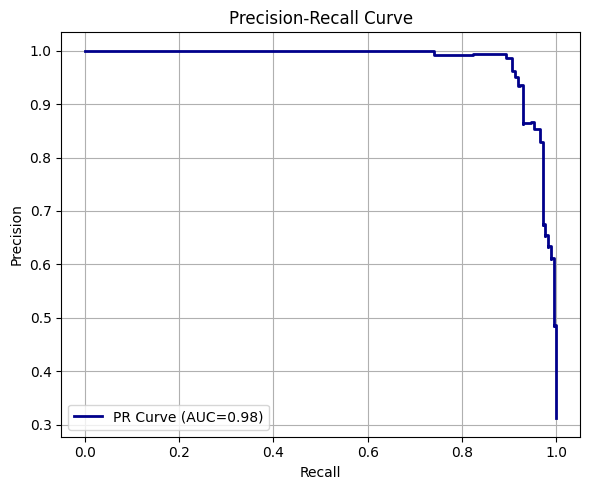

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

# plot PR curve
plt.figure(figsize=(6,5))
plt.step(recall, precision, where='post', color='darkblue', linewidth=2,
         label=f'PR Curve (AUC={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Precision-Recall Curve (Smoothed)

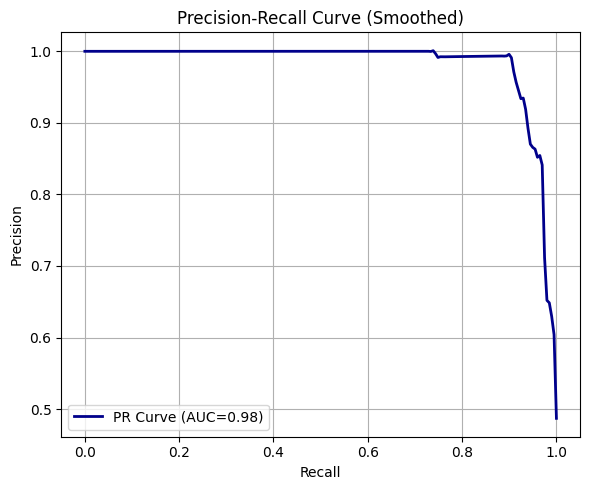

In [ ]:
recall_rev = recall[::-1]
precision_rev = precision[::-1]

_, unique_idx = np.unique(recall_rev, return_index=True)
recall_unique = recall_rev[unique_idx]
precision_unique = precision_rev[unique_idx]

recall_smooth = np.linspace(recall_unique.min(), recall_unique.max(), 200)
spl = make_interp_spline(recall_unique, precision_unique, k=3)
precision_smooth = spl(recall_smooth)

plt.figure(figsize=(6,5))
plt.plot(recall_smooth, precision_smooth, color='darkblue', linewidth=2,
         label=f'PR Curve (AUC={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Smoothed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## ROC Curve

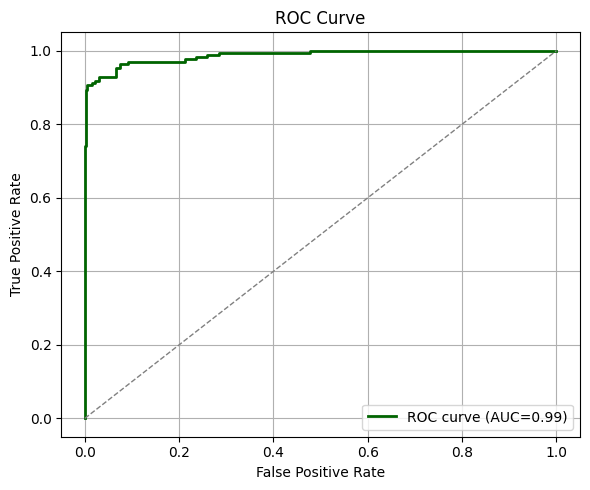

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve


fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)



plt.figure(figsize=(6,5))
plt.step(fpr, tpr, where='post', color='darkgreen', lw=2, label=f'ROC curve (AUC={roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## ROC Curve (Smoothed)

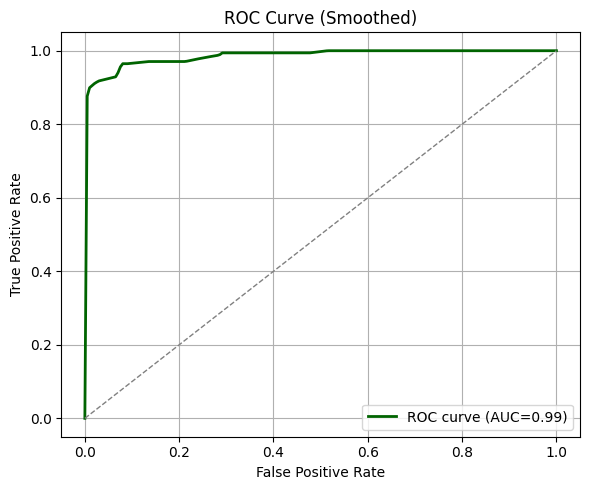

In [ ]:
from scipy.interpolate import interp1d

fpr_unique, idx = np.unique(fpr, return_index=True)
tpr_unique = tpr[idx]

roc_fpr_smooth = np.linspace(fpr_unique.min(), fpr_unique.max(), 200)
interp = interp1d(fpr_unique, tpr_unique, kind='linear')
roc_tpr_smooth = interp(roc_fpr_smooth)

plt.figure(figsize=(6,5))
plt.plot(roc_fpr_smooth, roc_tpr_smooth, color='darkgreen', lw=2, label=f'ROC curve (AUC={roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Smoothed)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
